# CharRNN

# Import

For Data Processing

In [1]:
import re
import random
import string

For Model Building

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

For PostProcessing

In [3]:
import matplotlib.pyplot as plt

# Read Data

In [4]:
all_chars = string.printable
total_num_chars = len(all_chars)

f = open("./Data/tinyshakespeare.txt","r")
content = f.read()
content_length = len(content)

Split Train and Valid

In [5]:
train_chars = content[:-5000]
valid_chars = content[-5000:]

Obtain Mini-batch, define size of mini-batch here

In [6]:
MINIBATCH = 200

Useful Functions for Feature Generation

In [7]:
def random_batch_char():
    random_index = random.randint(0, len(train_chars) - MINIBATCH-1)
    return train_chars[random_index:random_index+MINIBATCH+1]

In [8]:
def char2tensor(inputs):
    t = torch.zeros(len(inputs)).long()
    for count in range(len(inputs)):
        t[count] = all_chars.index(inputs[count])
    return Variable(t)

In [9]:
def random_training_batch():
    batch_chars = random_batch_char()
    inputs = char2tensor(batch_chars[:-1])
    tags = char2tensor(batch_chars[1:])
    return inputs, tags

# Define Model

In [10]:
class RNN(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, n_layers=1):
        super(RNN,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_dim, hidden_dim)
        self.net = nn.RNN(hidden_dim, hidden_dim, n_layers)
        self.decoder = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, inputs, hidden):
        inputs = self.encoder(inputs.view(1,-1))
        output, hidden = self.net(inputs.view(1,1,-1),hidden)
        output = self.decoder(output.view(1,-1))
        return output, hidden
    
    def hidden_init(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_dim))

Configure Parameter

In [11]:
NUM_LAYER = 1
HIDDEN_DIM = 100
model = RNN(total_num_chars, HIDDEN_DIM, total_num_chars, NUM_LAYER)

# Training Process

In [12]:
MAX_ITERATION = 20000
PRINT_PER = 100
LEARNING_RATE = 0.005

In [13]:
model_optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [14]:
def train(inputs, tags):
    hidden = model.hidden_init()
    model.zero_grad()
    loss = 0
    for count in range(MINIBATCH):
        output, hidden = model(inputs[count], hidden)
        loss += criterion(output, tags[count])  
    loss.backward()
    model_optimizer.step()
    return loss.data[0]/MINIBATCH

def valid(inputs, tags):
    hidden = model.hidden_init()
    model.zero_grad()
    loss = 0
    for count in range(len(inputs)):
        output, hidden = model(inputs[count], hidden)
        loss += criterion(output, tags[count]) 
    return loss.data[0]/len(inputs)

In [15]:
saved_train_loss = []
saved_valid_loss = []

In [16]:
valid_inputs = char2tensor(valid_chars[:-1])
valid_tags = char2tensor(valid_chars[1:])

In [17]:
averaged_loss = 0
for epoch in range(1,MAX_ITERATION):
    loss = train(*random_training_batch())
    averaged_loss += loss
    if epoch % PRINT_PER == 0:
        valid_loss = train(valid_inputs,valid_tags)
        print("epoch: " + str(epoch) + "\ttrain_loss: " + 
              str(averaged_loss/PRINT_PER) + "\tvalid_loss: " +
             str(valid_loss))
        saved_train_loss.append(averaged_loss/PRINT_PER)
        saved_valid_loss.append(valid_loss)
        averaged_loss = 0
    

epoch: 100	train_loss: 2.650787185668946	valid_loss: 2.3371041870117186
epoch: 200	train_loss: 2.2442281280517573	valid_loss: 2.278631591796875
epoch: 300	train_loss: 2.1485995529174806	valid_loss: 2.2290899658203127
epoch: 400	train_loss: 2.1091544418334967	valid_loss: 2.1525143432617186
epoch: 500	train_loss: 2.0771607360839837	valid_loss: 2.0541583251953126
epoch: 600	train_loss: 2.0426654220581053	valid_loss: 2.016005859375
epoch: 700	train_loss: 1.9968168319702142	valid_loss: 2.112503967285156
epoch: 800	train_loss: 1.9517124679565427	valid_loss: 1.9992787170410156
epoch: 900	train_loss: 1.9507220199584965	valid_loss: 2.033091735839844
epoch: 1000	train_loss: 1.9477157684326167	valid_loss: 1.9355213928222657
epoch: 1100	train_loss: 1.9359496353149408	valid_loss: 1.96572509765625
epoch: 1200	train_loss: 1.9110012725830066	valid_loss: 1.8906988525390624
epoch: 1300	train_loss: 1.915879180908203	valid_loss: 1.8974311828613282
epoch: 1400	train_loss: 1.8999470291137694	valid_loss: 1.8

KeyboardInterrupt: 

# Plot

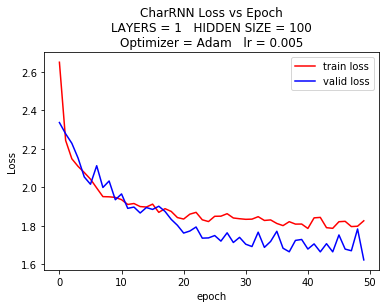

In [18]:
plt.figure()
plt.title('CharRNN Loss vs Epoch\n'+'LAYERS = '+str(NUM_LAYER)+'   HIDDEN SIZE = '+str(HIDDEN_DIM)+'\nOptimizer = Adam'+'   lr = '+str(LEARNING_RATE))
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.plot(saved_train_loss,'red')
plt.plot(saved_valid_loss,'blue')
plt.legend(['train loss','valid loss'])
plt.savefig('HW4_CharRNN_loss_'+str(NUM_LAYER)+'_hidden_'+str(HIDDEN_DIM)+'_Adam_lr_'+str(LEARNING_RATE)[2:])
plt.show()

# Genreate New Content

In [19]:
def generator(prime, gen_length, temperature):
    hidden = model.hidden_init()
    prime_tensor = char2tensor(prime)
    result_str = prime
    
    # Initialize the model by prime input
    for num in range(len(prime_tensor)-1):
        _, hidden = model(prime_tensor[num], hidden)
    inputs = prime_tensor[-1]
    
    # Start generating
    for count in range(gen_length):
        output, hidden = model(inputs, hidden)
        
        # Get Predict Result based on the probability divided by temperature
        p_dist = output.data.view(-1).div(temperature).exp()
        result_idx = torch.multinomial(p_dist, 1)[0]

        # Collect the predicted result
        next_char = all_chars[result_idx]
        result_str += next_char
        inputs = char2tensor(next_char)
    
    return result_str

In [22]:
PRIME = 'CORIOLANUS:'
PREDICT_LENGTH = 5000
T = 0.5
print(generator(PRIME,PREDICT_LENGTH,T))

CORIOLANUS:
Which the groshiness stay the grace of the quent and say late speak of of go it is the at of the not the dost a the consteep and shouse at she the good and how sun a son shrown to are shall his souls and say a son hath so stalt:

KING RICHARD III:
I shall not the worth shipot there are the shouse the still of the father shirly be and must good and with have it be thee for have a speak of the seen hath liven gone a give shouse have so the so with you the good, and morts go thy world and he disture at the pity the say and south lord, and so be we the good that the gosse:
Words have the strong a should should the he be of this son the son and slail the says in her a manion looks and worster.

KING RICHARD III:
What the be him shall good and all the she say shall him.

KING RICHOLIO:
Ge a good blood reath good the stain the be not the latter the some shall the say in your so soned have stay the quend good she grace.

KING RICHARD III:
I shall got give she she she here the marbo